In [1]:
%cd /Users/apple/Documents/My_GITHUB/DataScience_Projects/Image_classification_malaria

/Users/apple/Documents/My_GITHUB/DataScience_Projects/Image_classification_malaria


# Import libraries

In [2]:
##########################################################
# Import Python libraries
##########################################################
import glob
import sys
import os
import tqdm
import time
import random
from collections import Counter
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

##########################################################
# Import Tensorflow libraries
##########################################################
import tensorflow as tf
from tensorflow.keras import models, layers

##########################################################
# Import Custom-made libraries
##########################################################
sys.path += ['src']

import utils as utils
import train_test_split as splt
import data_preprocessing as process
import cnn_model as cnn
import model_training as train

ModuleNotFoundError: No module named 'utils'

# 1. Loading Data

In [ ]:
BASE = "/Users/apple/Documents/My_GITHUB/DataScience_Projects/Image_classification_malaria"

### Loading malaria data

In [4]:
malaria_files = utils.get_malaria_files(BASE, 'data')

print("Number of malaria JPEG images = {}".format(len(malaria_files)))

Number of malaria JPEG images = 5493


### Loading no malaria data

In [5]:
no_malaria_files = utils.get_no_malaria_files(BASE, 'data')

print("Number of no malaria JPEG images = {}".format(len(no_malaria_files)))

Number of no malaria JPEG images = 7258


# 2. Splitting the data into train and test samples

The test samples are randomly sampled from the whole dataset. The remainning number of samples are used for training.

**The test dataset is sampled to have balanced class labels.**

**Labelling convention:**
1. Label 1: Malaria
2. Label 0: No malaria

In [6]:
X_train, y_train, X_test, y_test = splt.make_train_test_split(BASE, 'data', test_size=0.2)

In [7]:
assert len(X_train) == len(y_train)

In [8]:
assert len(X_test) == len(y_test)

In [9]:
print("Number of train files={}".format(len(X_train)))

Number of train files=10201


In [10]:
print("Number of test files={}".format(len(X_test)))

Number of test files=2550


In [11]:
# Balanced class labels in test
Counter(y_test)

Counter({1: 1275, 0: 1275})

# 3. Data preprocessing

### A. Make tensorflow dataset: 
The first aim is to preprocess the data so that the JPEG files can be converted to Tensorflow Datasets.

In [12]:
train_dataset = process.make_tf_dataset(X_train, y_train)

In [13]:
test_dataset = process.make_tf_dataset(X_test, y_test)

### B. Data preprocessing:
1. Read the JPEG files, 
2. convert them to float 32 
3. and resize all images to the same shape
4. Perform data augumentation

The plotting_dataset is a sample to show the preprocessing step through plotting.

In [14]:
plotting_dataset = train_dataset.map(lambda X, y: process.encode(X, y))

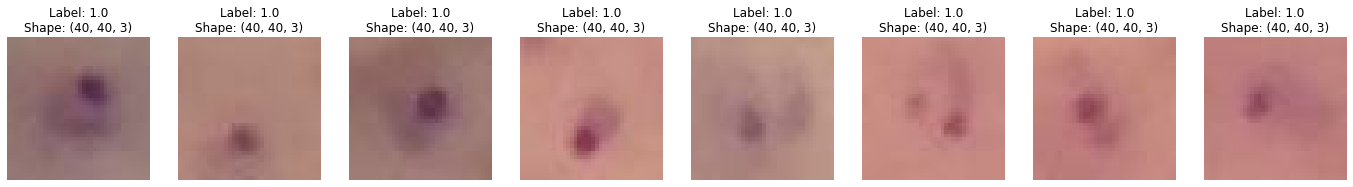

In [15]:
# Plot 8 samples for visualization
utils.plot_sample_images(plotting_dataset, num_samples=8)

In [16]:
plotting_dataset = plotting_dataset.map(lambda img, lab: process.data_augumentation(img, lab))

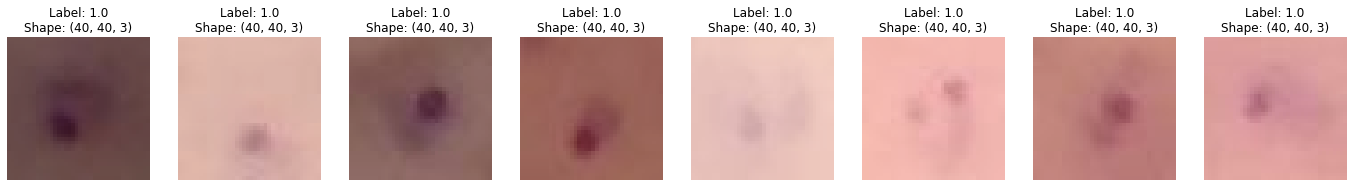

In [17]:
# Plot 8 samples after data augumentation
utils.plot_sample_images(plotting_dataset, num_samples=8)

# 4. Model training

### Global variables for model training

In [18]:
EPOCHS = 10
BATCH_SIZE = 64
TRAIN_SIZE = len(X_train)
NUM_OF_BATCHES = np.floor(TRAIN_SIZE / BATCH_SIZE)

### Prepare the training dataset

In [19]:
train_batched = train_dataset.map(lambda img, lab: process.encode(img, lab))
train_batched = train_batched.cache()
train_batched = train_batched.map(lambda img, lab: process.data_augumentation(img, lab))
train_batched = train_batched.shuffle(TRAIN_SIZE)
train_batched = train_batched.batch(BATCH_SIZE)

### Prepare the test dataset

In [20]:
test_batched = test_dataset.map(lambda img, lab: process.encode(img,lab))
test_batched = test_batched.cache()
test_batched = test_batched.batch(BATCH_SIZE)

### Build a Convolutional Neural Network model using Tensorflow

In [21]:
new_model = cnn.build_model(40, 40, 3)
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 40, 40, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 3200)              0

### Model training

1. Calculate the loss every batch.
2. Use GradientTape to calculate the gradient of the loss and update the trainable weights
3. If epoch number < 70% of total no. of epochs:
        Train the whole network

    If epoch number > 70% of total no. of epochs:
        Train only the Dense layers and freeze rest.

In [22]:
# Define optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [23]:
train.train_model(Epochs=EPOCHS,
                  train_data=train_batched,
                  model=new_model,
                  opt=optimizer,
                  num_of_batches=NUM_OF_BATCHES
                 )

[INFO] Executing epoch 1/10...
Elapsed time=0.820902419090271
Loss=0.5357171893119812
[INFO] Executing epoch 2/10...
Elapsed time=0.39897738297780355
Loss=0.3925512433052063
[INFO] Executing epoch 3/10...
Elapsed time=0.4251423478126526
Loss=0.35934171080589294
[INFO] Executing epoch 4/10...
Elapsed time=0.38149189949035645
Loss=0.3516412079334259
[INFO] Executing epoch 5/10...
Elapsed time=0.38912320137023926
Loss=0.3411995768547058
[INFO] Executing epoch 6/10...
Elapsed time=0.4110504309336344
Loss=0.3362928330898285
[INFO] Executing epoch 7/10...
Elapsed time=0.39956716696421307
Loss=0.3374585211277008
[INFO] Executing epoch 8/10...
Elapsed time=0.38950764735539756
Loss=0.32689613103866577
[INFO] Executing epoch 9/10...
Elapsed time=0.4180405616760254
Loss=0.3287130296230316
[INFO] Executing epoch 10/10...
Elapsed time=0.38336201508839923
Loss=0.32275742292404175


### Model evaluation

In [24]:
new_model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy']
                 )

In [25]:
(loss, accuracy) = new_model.evaluate(test_batched)

40/40 [==============================] - 4s 75ms/step - loss: 0.2558 - accuracy: 0.9195


# 5. Future Improvements

1. More capacity could be added in the model to see if it gives a better performance.

2. The model parameters are not yet optimized. So is the number of epochs, batch size and so on

3. A proper inference protocol is missing now i.e. separating the data into train, test, validation.

4. At present only the Dense layers are trained after exausting 70% of epochs. Instead of that one could set a threshold criterion: for example if the validation loss goes below a certain threshold, then freeze the convolutional layers and only train the dense layers.

5. One could also add one layer at a time after freezing the convolutional layers, train on the newly added layer and continue this process iteratively by gradually adding more capacity to the model. By adding layers successively, the training process can be made faster and more deeper networks can be built.